# Image classification with Vision Transformer

This code follows "[Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)" tutorial of Keras.
We made some editions to make this code able to run with Keras 2 (the version of Keras on Google Colab on check date 3 May 2024) and match the ViT architecture proposed by [AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://openreview.net/pdf?id=YicbFdNTTy)


## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

# Baseline setup

In [1]:
import os
import tensorflow as tf
import tensorflow.keras as keras
# import keras
from keras import layers
# from keras import ops

import numpy as np
import matplotlib.pyplot as plt

2024-08-28 21:57:50.502769: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Prepare the data

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 20
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier
dropout_rate = 0.1

## Use data augmentation

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


2024-08-28 21:57:53.572662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 21:57:54.090590: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18271 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:31:00.0, compute capability: 8.6


## Implement multilayer perceptron (MLP)

In [5]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [6]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = images.shape
        batch_size = tf.shape(images)[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        p_s = [1, self.patch_size, self.patch_size, 1]
        patches = tf.image.extract_patches(images, sizes=p_s, strides=p_s, rates=[1,1,1,1], padding='VALID')

        patches = tf.reshape(patches, (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


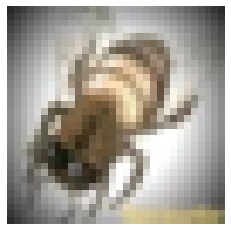

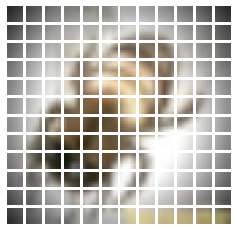

In [7]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [8]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches+1
        self.cls_token = tf.Variable(initial_value=tf.random.normal([1, 1, projection_dim]))
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.expand_dims(
            tf.range(start=0, limit=self.num_patches, delta=1), axis=0
        )
        bz = tf.shape(patch)[0]
        cls_tokens = tf.repeat(self.cls_token, bz, axis=0)
        projected_patches = self.projection(patch)
        projected_token = tf.concat([cls_tokens, projected_patches], axis=1)
        encoded = projected_token + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config


# Task 3 - Implement the MultiHeadAttention module

You are required to implement the MultiHeadAttention module on your own. You may want to check for [Tensorflow tutorial on implemetation a custom layer](https://www.tensorflow.org/tutorials/customization/custom_layers)

In [9]:
# TODO: you can choose to implement the MultiHeadAttention module as a Layer or as a Model and use the corresponding code block
class My_MultiHeadAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(My_MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        
        assert embed_dim % num_heads == 0
        
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output

    def call(self, inputs):
        query, key, value = inputs, inputs, inputs
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])


## Build the ViT model

In [10]:
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.backend import softmax

In [11]:
class My_MultiHeadAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads, value_dim, output_dim):
        super(My_MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.value_dim = value_dim
        self.output_dim = output_dim
        
        assert embed_dim % num_heads == 0
        assert value_dim % num_heads == 0
        
        self.projection_dim = embed_dim // num_heads
        self.value_projection_dim = value_dim // num_heads

        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(value_dim)
        self.output_dense = layers.Dense(output_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output

    def call(self, inputs):
        query, key, value = inputs, inputs, inputs
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.separate_heads(query, batch_size, self.projection_dim)
        key = self.separate_heads(key, batch_size, self.projection_dim)
        value = self.separate_heads(value, batch_size, self.value_projection_dim)

        attention = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.value_dim))
        output = self.output_dense(concat_attention)
        return output

    def separate_heads(self, x, batch_size, projection_dim):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])


# Updating the ViT model creation
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        att_module = My_MultiHeadAttention(embed_dim=128, num_heads=num_heads, value_dim=128, output_dim=64)
        attention_output = att_module(x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
    
    encoded_cls = encoded_patches[:, 0]
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_cls)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class My_MultiHeadAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads, value_dim, output_dim):
        super(My_MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.value_dim = value_dim
        self.output_dim = output_dim
        
        assert embed_dim % num_heads == 0
        assert value_dim % num_heads == 0
        
        self.projection_dim = embed_dim // num_heads
        self.value_projection_dim = value_dim // num_heads

        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(value_dim)
        self.output_dense = layers.Dense(output_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)  # (batch_size, num_heads, n+1, n+1)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)  # (batch_size, num_heads, n+1, value_projection_dim)
        return output

    def call(self, inputs):
        query, key, value = inputs, inputs, inputs
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)  # (batch_size, n+1, embed_dim)
        key = self.key_dense(key)  # (batch_size, n+1, embed_dim)
        value = self.value_dense(value)  # (batch_size, n+1, value_dim)

        # Reshape and transpose
        query = tf.reshape(query, (batch_size, -1, self.num_heads, self.projection_dim))
        query = tf.transpose(query, perm=[0, 2, 1, 3])
        
        key = tf.reshape(key, (batch_size, -1, self.num_heads, self.projection_dim))
        key = tf.transpose(key, perm=[0, 2, 1, 3])
        
        value = tf.reshape(value, (batch_size, -1, self.num_heads, self.value_projection_dim))
        value = tf.transpose(value, perm=[0, 2, 1, 3])

        attention = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        # print("Attention shape:", attention.shape)
        concat_attention = tf.reshape(attention, (batch_size, -1, self.num_heads * self.value_projection_dim))
        # print("Concat attention shape:", concat_attention.shape)
        output = self.output_dense(concat_attention)  # (batch_size, n+1, output_dim)
        # print("Output shape:", output.shape)
        return output

# Example usage
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        att_module = My_MultiHeadAttention(embed_dim=128, num_heads=2, value_dim=128, output_dim=64)
        attention_output = att_module(x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
    
    encoded_cls = encoded_patches[:, 0]
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_cls)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Compile, train, and evaluate the mode

In [13]:
def plot_history(history, item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

In [14]:
vit_classifier = create_vit_classifier()

/root/miniconda3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure

Epoch 1/100
  1/176 [..............................] - ETA: 35:41 - loss: 4.6542 - accuracy: 0.0000e+00

2024-08-28 14:56:41.517111: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


176/176 [==============================] - 37s 141ms/step - loss: 4.1980 - accuracy: 0.0559 - val_loss: 3.8113 - val_accuracy: 0.1012
Epoch 2/100
176/176 [==============================] - 23s 129ms/step - loss: 3.8488 - accuracy: 0.0999 - val_loss: 3.5932 - val_accuracy: 0.1384
Epoch 3/100
176/176 [==============================] - 23s 129ms/step - loss: 3.6920 - accuracy: 0.1225 - val_loss: 3.4365 - val_accuracy: 0.1676
Epoch 4/100
176/176 [==============================] - 23s 130ms/step - loss: 3.5359 - accuracy: 0.1487 - val_loss: 3.2709 - val_accuracy: 0.1928
Epoch 5/100
176/176 [==============================] - 23s 130ms/step - loss: 3.4208 - accuracy: 0.1672 - val_loss: 3.2353 - val_accuracy: 0.1956
Epoch 6/100
176/176 [==============================] - 23s 129ms/step - loss: 3.3412 - accuracy: 0.1813 - val_loss: 3.1071 - val_accuracy: 0.2240
Epoch 7/100
176/176 [==============================] - 23s 130ms/step - loss: 3.2579 - accuracy: 0.1955 - val_loss: 3.0503 - val_accurac

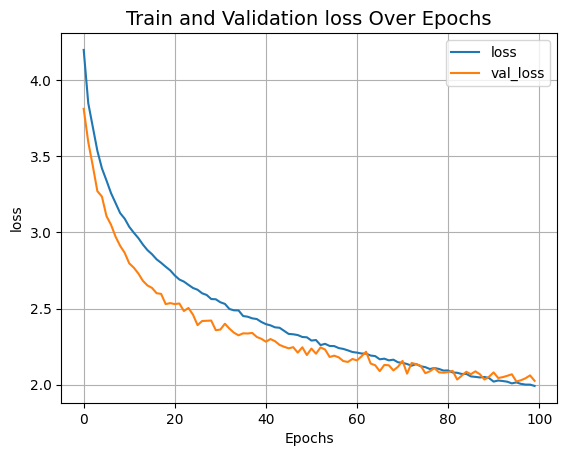

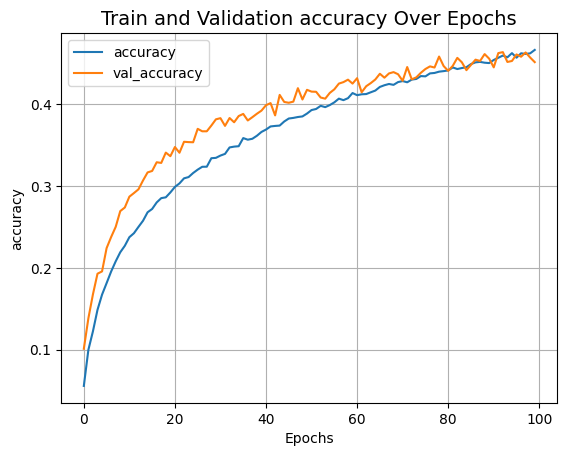

In [15]:
# optimizer = keras.optimizers.AdamW(
#         learning_rate=learning_rate, weight_decay=weight_decay
#     )
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)
vit_classifier.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

checkpoint_filepath = "/tmp/checkpoint.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

history = vit_classifier.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=100,
    validation_split=0.1,
    callbacks=[checkpoint_callback],
)
plot_history(history, "loss")
plot_history(history, "accuracy")

In [16]:
# Load weights from the checkpoint file and evaluate
vit_classifier.load_weights(checkpoint_filepath)
_, accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

313/313 [==============================] - 5s 15ms/step - loss: 2.0287 - accuracy: 0.4698
Test accuracy: 46.98%


# Task 4 - Implement the MultiHeadAttention layer from scratch

In [14]:
def create_vit_classifier(patch_size, num_heads, projection_dim, transformer_layers):
    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    num_patches = (input_shape[0] // patch_size) ** 2
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        att_module = My_MultiHeadAttention(
            embed_dim=projection_dim, num_heads=num_heads, value_dim=projection_dim, output_dim=projection_dim
        )
        attention_output = att_module(x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
    
    encoded_cls = encoded_patches[:, 0]
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_cls)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [20]:
import tensorflow as tf
import pickle
optimizer = tf.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)
checkpoint_filepath = "/tmp/checkpoint.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)
def create_vit_classifier(patch_size, num_heads, projection_dim, transformer_layers):
    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    num_patches = (augmented.shape[1] // patch_size) ** 2
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        att_module = My_MultiHeadAttention(
            embed_dim=projection_dim, num_heads=num_heads, value_dim=projection_dim, output_dim=projection_dim
        )
        attention_output = att_module(x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=[projection_dim*2,projection_dim], dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
    
    encoded_cls = encoded_patches[:, 0]
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_cls)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

def evaluate_hyperparameters(param_name, values, base_params):
    global best_val_accuracy, best_hyperparameters
    histories = {}    
    for value in values:
        params = base_params.copy()
        params[param_name] = value
        
        print(f"Training with {param_name}={value}")
        vit_classifier = create_vit_classifier(
            params['patch_size'], 
            params['num_heads'], 
            params['projection_dim'], 
            params['transformer_layers']
        )
        
        vit_classifier.compile(
            optimizer=optimizer,
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"],
        )
        
        history = vit_classifier.fit(
            x=x_train,
            y=y_train,
            batch_size=batch_size,
            epochs=2,
            validation_split=0.1,
            callbacks=[checkpoint_callback],
        )
        # Save history to a local file
        history_file = f"history_{param_name}_{value}.pkl"
        with open(history_file, "wb") as f:
            pickle.dump(history.history, f)
        
        print(f"Saved history to {history_file}")
        # Save history
        histories[f"{param_name}={value}"] = history.history        
        val_accuracy = max(history.history["val_accuracy"])
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_hyperparameters = params
        
        print(f"Val accuracy: {val_accuracy:.4f}")
    return histories
# Base parameters
base_params = {
    "patch_size": 8,
    "num_heads": 4,
    "projection_dim": 128,
    "transformer_layers": 8
}

# Evaluate different settings
best_val_accuracy = 0
best_hyperparameters = {}



Training with patch_size=4
Epoch 1/20


2024-08-28 22:07:15.313402: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


176/176 [==============================] - 104s 523ms/step - loss: 4.2049 - accuracy: 0.0562 - val_loss: 3.8458 - val_accuracy: 0.1032
Epoch 2/20
126/176 [====================>.........] - ETA: 24s - loss: 3.8510 - accuracy: 0.0966

KeyboardInterrupt: 

In [ ]:
evaluate_hyperparameters("patch_size", [8,12], base_params)

In [ ]:
evaluate_hyperparameters("num_heads", [2, 8], base_params)

In [ ]:
evaluate_hyperparameters("projection_dim", [64, 256], base_params)

In [ ]:
evaluate_hyperparameters("transformer_layers", [4, 12], base_params)

In [ ]:
# Collecting all histories
# all_histories = {}
# all_histories.update(evaluate_hyperparameters("patch_size", [8, 12], base_params))
# all_histories.update(evaluate_hyperparameters("num_heads", [2, 8], base_params))
# all_histories.update(evaluate_hyperparameters("projection_dim", [64, 256], base_params))
# all_histories.update(evaluate_hyperparameters("transformer_layers", [4, 12], base_params))

# Plotting function
# def plot_all_histories(histories):
#     plt.figure(figsize=(12, 6))
    
#     # Plot accuracy
#     plt.subplot(1, 2, 1)
#     for key, history in histories.items():
#         plt.plot(history['accuracy'], label=f'{key} train')
#         plt.plot(history['val_accuracy'], linestyle='--', label=f'{key} val')
#     plt.title('Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     # Plot loss
#     plt.subplot(1, 2, 2)
#     for key, history in histories.items():
#         plt.plot(history['loss'], label=f'{key} train')
#         plt.plot(history['val_loss'], linestyle='--', label=f'{key} val')
#     plt.title('Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.show()

# # Plot all histories
# plot_all_histories(all_histories)

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Function to load history from a file
def load_history(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

# Function to plot the comparison of different histories
def plot_comparison(history_files):
    plt.figure(figsize=(12, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    for file_path in history_files:
        history = load_history(file_path)
        label = file_path.split('.')[0]  # Use file name as label
        plt.plot(history['accuracy'], label=f'{label} train')
        plt.plot(history['val_accuracy'], linestyle='--', label=f'{label} val')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for file_path in history_files:
        history = load_history(file_path)
        label = file_path.split('.')[0]
        plt.plot(history['loss'], label=f'{label} train')
        plt.plot(history['val_loss'], linestyle='--', label=f'{label} val')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# List of history files to compare
history_files = [
    "history_patch_size_8.pkl",
    "history_patch_size_12.pkl",
    "history_num_heads_2.pkl",
    "history_num_heads_8.pkl",
    "history_projection_dim_64.pkl",
    "history_projection_dim_256.pkl",
    "history_transformer_layers_4.pkl",
    "history_transformer_layers_12.pkl"
]

# Plot the comparison
plot_comparison(history_files)

In [ ]:
print("best hyperparameters:",best_hyperparameters)
print("best valid accuracy",best_val_accuracy)